In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch
from torchvision.models import vit_b_16
from torchvision import transforms
from PIL import Image
from collections import OrderedDict

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
import shutil
from PIL import Image
import numpy as np

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
folder_path = r'/content/drive/MyDrive/fake_currency/Indian Currency Dataset'

In [ ]:
train = os.path.join(folder_path, 'train')
test = os.path.join(folder_path, 'test')
validate = os.path.join(folder_path, 'validation')

In [ ]:
len(train)

66

In [ ]:
len(test)

65

In [ ]:
len(validate)

71

In [ ]:
train_fake = os.path.join(train, 'fake')
train_real = os.path.join(train, 'real')

In [ ]:
train_fake_images = [os.path.join(train_fake, img) for img in os.listdir(train_fake)]
train_real_images = [os.path.join(train_real, img) for img in os.listdir(train_real)]

In [ ]:
train_fake, val_fake = train_test_split(train_fake_images, test_size=0.15, random_state=42)
train_real, val_real = train_test_split(train_real_images, test_size=0.15, random_state=42)

In [ ]:
train_images = train_fake + train_real
val_images = val_fake + val_real

In [ ]:
validation = os.path.join(folder_path, 'validation')
os.makedirs(validation, exist_ok=True)

In [ ]:
val_fake = os.path.join(validation, 'fake')
val_real = os.path.join(validation, 'real')
os.makedirs(val_fake, exist_ok=True)
os.makedirs(val_real, exist_ok=True)

In [ ]:
print(f'Train set size: {len(train_images)}')
print(f'Validation set size: {len(val_images)}')

Train set size: 127
Validation set size: 23


In [ ]:
batch_size = 32
target_size = (224, 224)
train_generator = datagen.flow_from_directory(
    train,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

validation_generator = datagen.flow_from_directory(
    validation,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

test_generator = datagen.flow_from_directory(
    test,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    seed=42
)

Found 150 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Option A: freeze most layers but allow the last 40 to fine-tune
for layer in base_model.layers[:-40]:
    layer.trainable = False
for layer in base_model.layers[-40:]:
    layer.trainable = True


x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)


x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)


x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)


outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


num_epochs = 15
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 14s/step - accuracy: 0.4869 - loss: 1.0990 - val_accuracy: 0.4833 - val_loss: 0.7995
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - accuracy: 0.5142 - loss: 0.8429 - val_accuracy: 0.4833 - val_loss: 0.7672
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.5934 - loss: 0.7555 - val_accuracy: 0.4833 - val_loss: 0.7832
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.6360 - loss: 0.8058 - val_accuracy: 0.5000 - val_loss: 0.7262
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7076 - loss: 0.6625 - val_accuracy: 0.5500 - val_loss: 0.7364
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.7251 - loss: 0.5975 - val_accuracy: 0.5667 - val_loss: 0.6663
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.7760 - loss: 0.4939 - val_accuracy: 0.6333 - val_loss: 0.6443
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.7091 - loss: 0.5500 - val_accuracy: 0.6833 - val_loss: 0.6311
Epoch 9

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 4s/step - accuracy: 0.7661 - loss: 0.5320
Test Loss: 0.5180792212486267, Test Accuracy: 0.7850467562675476


In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)
print(f'Train Loss: {train_loss}, Train Accuracy: {train_accuracy}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7792 - loss: 0.5347
Train Loss: 0.5202028751373291, Train Accuracy: 0.7933333516120911


In [ ]:
predictions = model.predict(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


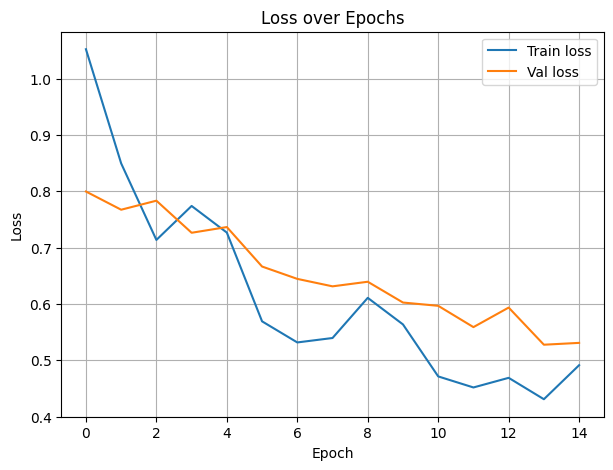

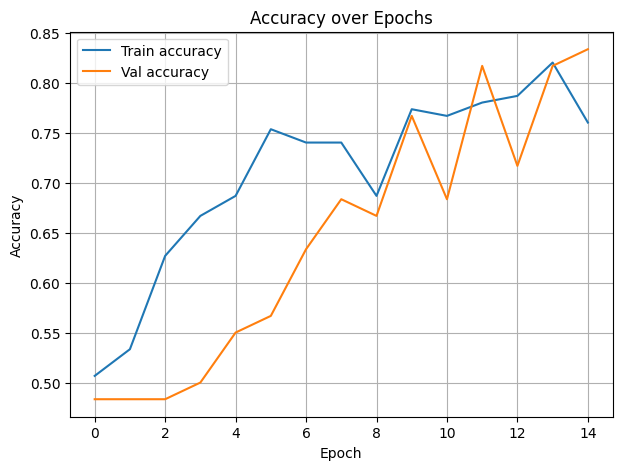

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    hist = history.history
    metrics_to_plot = ['loss', 'accuracy', 'precision', 'recall']

    for m in metrics_to_plot:
        if m not in hist:   # skip metrics you didn’t track
            continue
        plt.figure(figsize=(7,5))
        plt.plot(hist[m], label=f'Train {m}')
        plt.plot(hist[f'val_{m}'], label=f'Val {m}')
        plt.title(f'{m.capitalize()} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(m.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training(history)


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


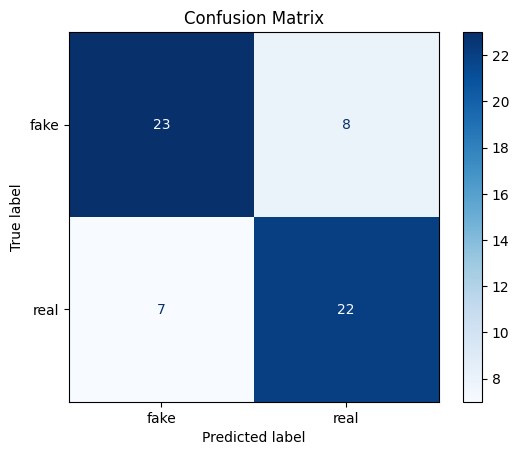

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predicted labels from the validation generator
val_labels = validation_generator.classes
val_preds  = model.predict(validation_generator)
val_preds_bin = (val_preds > 0.5).astype(int).ravel()

# Compute confusion matrix
cm = confusion_matrix(val_labels, val_preds_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=validation_generator.class_indices.keys())
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


              precision    recall  f1-score   support

        fake       0.77      0.74      0.75        31
        real       0.73      0.76      0.75        29

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60

ROC-AUC: 0.8542825361512792


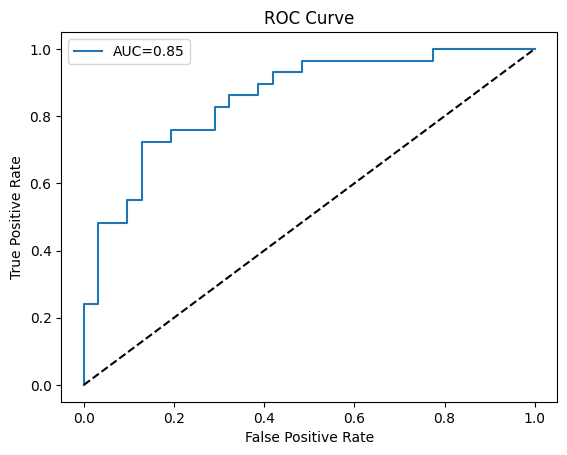

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

print(classification_report(val_labels, val_preds_bin, target_names=validation_generator.class_indices.keys()))

auc = roc_auc_score(val_labels, val_preds)
print("ROC-AUC:", auc)

# ROC curve
fpr, tpr, _ = roc_curve(val_labels, val_preds)
plt.plot(fpr, tpr, label=f'AUC={auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
classes =  ["fifty_new", "fifty_old", "five_hundred", "hundred_new", "hundred_old", "ten_new", "ten_old", "twenty_new", "twenty_old", "two_hundred", "two_thousand"]

In [ ]:
import torch

checkpoint_path = "/content/drive/MyDrive/fake_currency/best_model.pth"

# ✅ Explicitly allow full checkpoint loading
checkpoint = torch.load(checkpoint_path,
                        map_location=device,
                        weights_only=False)

In [ ]:
model.load_state_dict(checkpoint["model"])
model.to(device)
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/drive/MyDrive/fake_currency/model.keras')

# Function to preprocess image for the model
def preprocess_image(image):
    # Resize image to the size your model expects
    image = cv2.resize(image, (224, 224))
    # Normalize the image if needed
    image = image / 255.0
    # Expand dimensions to match input shape (1, height, width, channels)
    image = np.expand_dims(image, axis=0)
    return image

# Function for prediction
def predict_currency(image):
    processed_image = preprocess_image(image)
    prediction = model.predict(processed_image)
    return prediction

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Streamlit UI
st.title("Fake Currency Detection")

# Image upload section
uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    # Convert the uploaded file to an OpenCV image
    file_bytes = np.asarray(bytearray(uploaded_file.read()), dtype=np.uint8)
    image = cv2.imdecode(file_bytes, 1)

    # Display the uploaded image
    st.image(image, channels="BGR")

    if st.button('Detect'):
        st.write('Processing...')
        prediction = predict_currency(image)
        label = 'Fake Currency' if prediction[0][0] > 0.5 else 'Real Currency'
        st.write(f"Prediction: {label}")

In [ ]:
import matplotlib.pyplot as plt


Single Prediction: Fake Currency
Single Model raw output: 0.58
Average Score over 5 runs: 0.37
Final Prediction: Real Currency


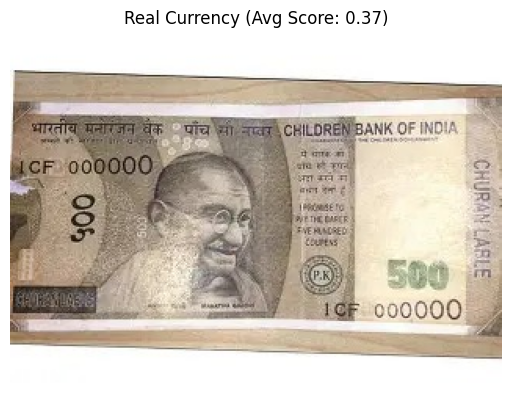

In [ ]:
# image = cv2.imread("/content/WhatsApp Image 2025-09-22 at 09.52.20.jpeg")
# image = cv2.imread("/content/WhatsApp Image 2025-09-22 at 09.52.52.jpeg")
image = cv2.imread("/content/WhatsApp Image 2025-09-22 at 11.03.58.jpeg")
prediction = predict_currency(image)
label_single = "Fake Currency" if prediction[0][0] > 0.4 else "Real Currency"
print(f"Single Prediction: {label_single}")
print(f"Single Model raw output: {prediction[0][0]:.2f}")

# --- Average multiple predictions ---
N = 5  # number of times to run prediction
scores = [predict_currency(image)[0][0] for _ in range(N)]
mean_score = np.mean(scores)

# Determine final label based on mean score
threshold = 0.4
if mean_score > threshold:
    final_label = "Fake Currency"
elif mean_score < threshold:
    final_label = "Real Currency"
else:
    final_label = "Uncertain"

print(f"Average Score over {N} runs: {mean_score:.2f}")
print(f"Final Prediction: {final_label}")

# Display image with final prediction as title
plt.imshow(image_rgb)
plt.axis('off')
plt.title(f"{final_label} (Avg Score: {mean_score:.2f})")
plt.show()

In [ ]:
!python --version

Python 3.12.11


In [ ]:
!pip show tensorflow


Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


Rotation 0° -> Score: 0.99 | Label: Fake Currency
Rotation 90° -> Score: 0.87 | Label: Fake Currency
Rotation 180° -> Score: 1.00 | Label: Fake Currency
Rotation 270° -> Score: 0.53 | Label: Fake Currency

Vote Summary:
Fake votes: 4, Real votes: 0
Final Prediction (Majority Vote): Fake Currency


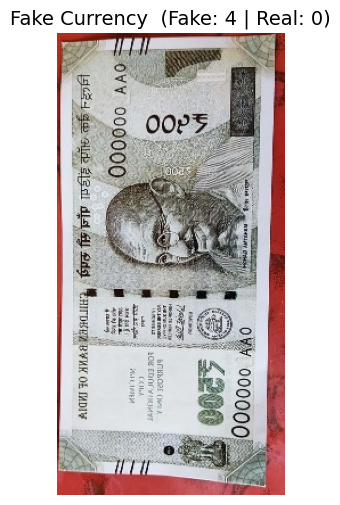

In [ ]:
#final code

import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1️⃣ Load the trained model (adjust the path if needed)
# -------------------------------------------------------------
model = load_model('/content/drive/MyDrive/fake_currency/Fake-currency.keras')

# -------------------------------------------------------------
# 2️⃣ Preprocess and prediction utilities
# -------------------------------------------------------------
def preprocess_image(image_bgr):
    """
    Resize & normalize for the model.
    Expects BGR image; returns shape (1, 224, 224, 3) float32.
    """
    image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)      # convert to RGB if model trained on RGB
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    return np.expand_dims(image, axis=0).astype(np.float32)

def predict_currency(image_bgr):
    """
    Return the probability of Fake currency (0–1).
    """
    processed = preprocess_image(image_bgr)
    pred = model.predict(processed, verbose=0)  # shape (1,1) or (1,2) depending on model
    # If model output is a single sigmoid neuron:
    score = float(pred[0][0])
    return score

# -------------------------------------------------------------
# 3️⃣ Majority-vote across rotations
# -------------------------------------------------------------
def currency_prediction_majority(image_path, threshold=0.4):
    """
    Rotate the image in 0°, 90°, 180°, 270° and predict each.
    Decide final label by majority vote.
    """
    image_bgr = cv2.imread(image_path)
    if image_bgr is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    rotations = {
        "0°":   image_bgr,
        "90°":  cv2.rotate(image_bgr, cv2.ROTATE_90_CLOCKWISE),
        "180°": cv2.rotate(image_bgr, cv2.ROTATE_180),
        "270°": cv2.rotate(image_bgr, cv2.ROTATE_90_COUNTERCLOCKWISE),
    }

    rotation_scores = {}
    rotation_labels = {}

    for angle, img in rotations.items():
        score = predict_currency(img)
        label = "Fake Currency" if score >= threshold else "Real Currency"
        rotation_scores[angle] = score
        rotation_labels[angle] = label
        print(f"Rotation {angle} -> Score: {score:.2f} | Label: {label}")

    # Majority vote
    fake_votes = sum(1 for lbl in rotation_labels.values() if lbl == "Fake Currency")
    real_votes = len(rotation_labels) - fake_votes
    final_label = "Fake Currency" if fake_votes >= real_votes else "Real Currency"

    print("\nVote Summary:")
    print(f"Fake votes: {fake_votes}, Real votes: {real_votes}")
    print(f"Final Prediction (Majority Vote): {final_label}")

    # Show original image with result
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(6, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"{final_label}  (Fake: {fake_votes} | Real: {real_votes})", fontsize=14)
    plt.show()

    return final_label, rotation_scores, rotation_labels

# -------------------------------------------------------------
# 4️⃣ Run it
# -------------------------------------------------------------
if __name__ == "__main__":
    img_path = "/content/WhatsApp Image 2025-09-22 at 09.52.20.jpeg"
    label, scores, labels = currency_prediction_majority(img_path, threshold=0.4)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


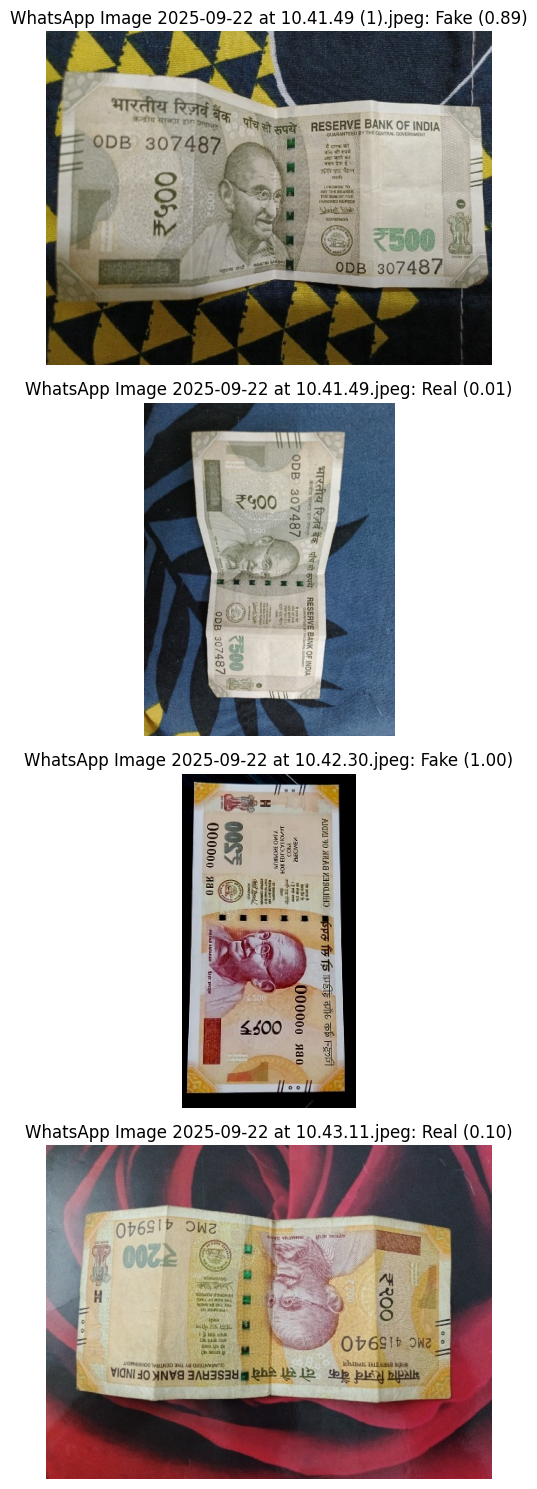

In [ ]:
  image_paths = [
    "/content/second_test/WhatsApp Image 2025-09-22 at 10.41.49 (1).jpeg",
    "/content/second_test/WhatsApp Image 2025-09-22 at 10.41.49.jpeg",
    "/content/second_test/WhatsApp Image 2025-09-22 at 10.42.30.jpeg",
    "/content/second_test/WhatsApp Image 2025-09-22 at 10.43.11.jpeg"
]

# Load images and predictions
images_rgb = []
predictions = []

for path in image_paths:
    image = cv2.imread(path)
    if image is None:
        print(f"Could not read {path}")
        continue
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images_rgb.append(image_rgb)

    pred = predict_currency(image)
    label = "Fake" if pred[0][0] > 0.5 else "Real"
    predictions.append((label, pred[0][0]))

# Display all images stacked vertically
fig, axes = plt.subplots(len(images_rgb), 1, figsize=(6, 15))

if len(images_rgb) == 1:
    axes = [axes]  # Ensure axes is iterable for a single image

for ax, img, (label, score), path in zip(axes, images_rgb, predictions, image_paths):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{path.split('/')[-1]}: {label} ({score:.2f})")

plt.tight_layout()
plt.show()

Stacked image saved at: stacked_prediction.jpg


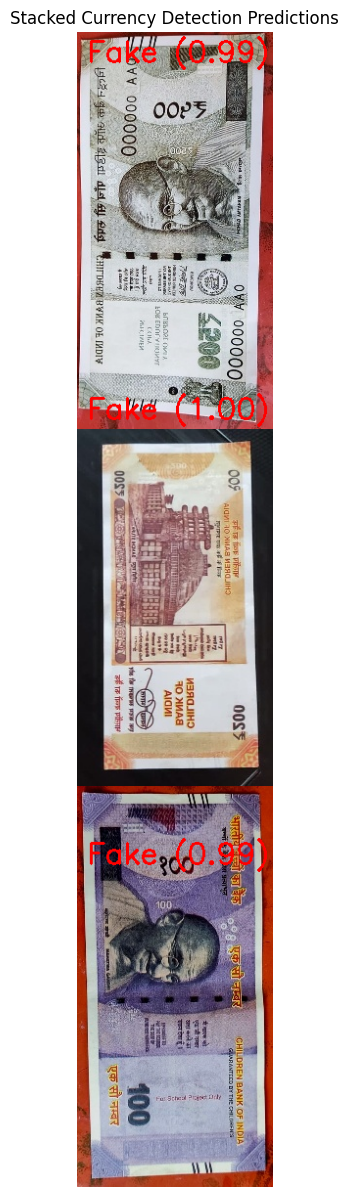

In [ ]:
stacked_image = np.vstack(images_rgb)

# Convert to BGR to use OpenCV for text overlay
stacked_bgr = cv2.cvtColor(stacked_image, cv2.COLOR_RGB2BGR)

# Overlay predictions as text on each section
y_offset = 30
for i, (label, score) in enumerate(predictions):
    # Position: top of each image block
    y = y_offset + i * images_rgb[i].shape[0]
    cv2.putText(stacked_bgr, f"{label} ({score:.2f})",
                (10, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# Save stacked image
output_path = "stacked_prediction.jpg"
cv2.imwrite(output_path, stacked_bgr)
print(f"Stacked image saved at: {output_path}")

# Display using matplotlib
plt.figure(figsize=(6, 15))
plt.imshow(cv2.cvtColor(stacked_bgr, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Stacked Currency Detection Predictions")
plt.show()

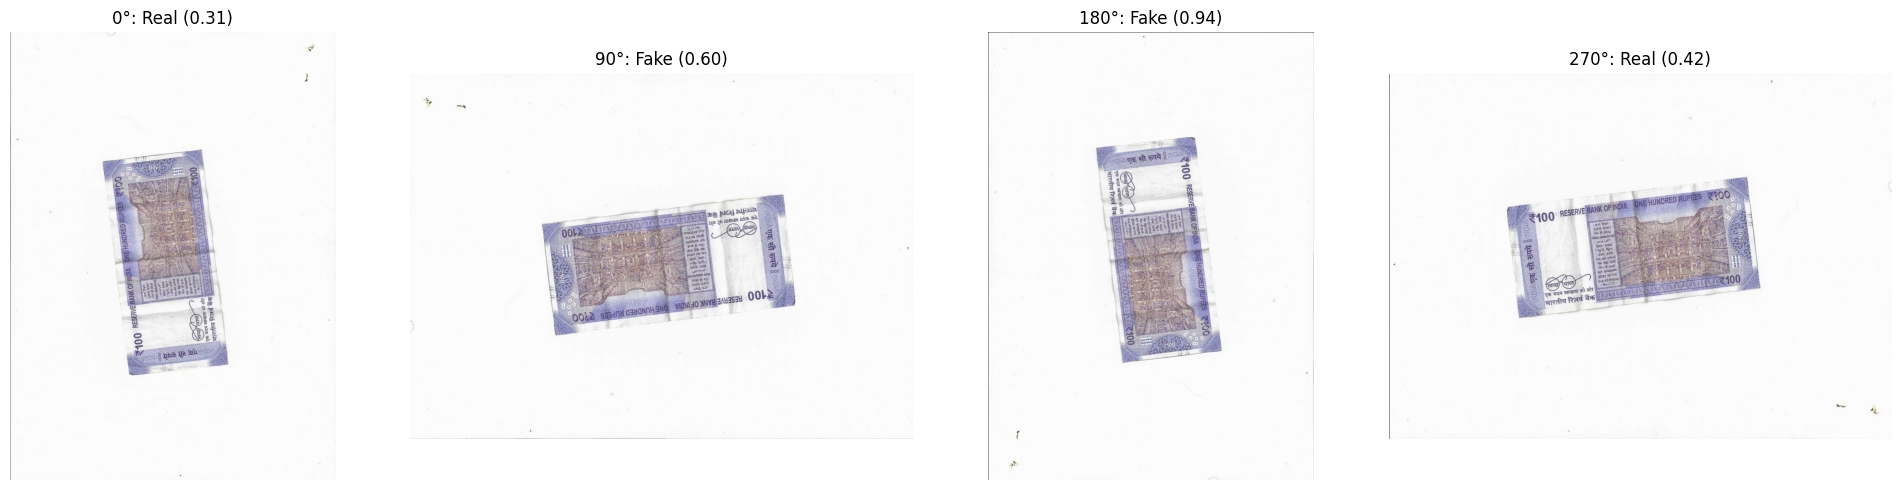

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Dummy prediction function ---
def predict_currency(image):
    import random
    return [[random.random()]]

# Load image
image_path = "/content/WhatsApp Image 2025-09-22 at 10.59.30.jpeg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Rotations in degrees
rotations = [0, 90, 180, 270]

rotated_images = []
predictions = []

for angle in rotations:
    h, w = image_rgb.shape[:2]
    # Compute the center of the image
    center = (w / 2, h / 2)

    # Get rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Compute the new bounding dimensions
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust the rotation matrix to take into account translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    # Perform the actual rotation
    rotated = cv2.warpAffine(image_rgb, M, (new_w, new_h))
    rotated_images.append(rotated)

    # Prediction
    pred = predict_currency(rotated)
    label = "Fake" if pred[0][0] > 0.5 else "Real"
    predictions.append((angle, label, pred[0][0]))

# Display all rotated images
fig, axes = plt.subplots(1, len(rotated_images), figsize=(20, 5))
for ax, img, (angle, label, score) in zip(axes, rotated_images, predictions):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{angle}°: {label} ({score:.2f})")

plt.tight_layout()
plt.show()
